# [**Agglomération de caractéristiques vs sélection univariée**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/2_3_cluster/plot_feature_agglomeration_vs_univariate_selection.ipynb)<br/>([*Feature agglomeration vs. univariate selection*](https://scikit-learn.org/stable/auto_examples/cluster/plot_feature_agglomeration_vs_univariate_selection.html))

Cet exemple compare 2 stratégies de réduction de dimensionnalité :
* sélection de caractéristiques univariées avec Anova
* agglomération d'entités avec le clustering hiérarchique Ward

Les deux méthodes sont comparées dans un problème de régression utilisant un BayesianRidge comme estimateur supervisé.

In [1]:
# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
# License: BSD 3 clause

In [5]:
import shutil
import tempfile

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, ndimage
from joblib import Memory

from sklearn.feature_extraction.image import grid_to_graph
from sklearn import feature_selection
from sklearn.cluster import FeatureAgglomeration
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# Définition des paramètres

In [6]:
n_samples = 200
size = 40  # image size
roi_size = 15
snr = 5.0
np.random.seed(0)

# Génération du jeu de données

In [7]:
coef = np.zeros((size, size))
coef[0:roi_size, 0:roi_size] = -1.0
coef[-roi_size:, -roi_size:] = 1.0

X = np.random.randn(n_samples, size**2)
for x in X:  # smooth data
    x[:] = ndimage.gaussian_filter(x.reshape(size, size), sigma=1.0).ravel()
X -= X.mean(axis=0)
X /= X.std(axis=0)

y = np.dot(X, coef.ravel())

ajout de bruit

In [8]:
noise = np.random.randn(y.shape[0])
noise_coef = (linalg.norm(y, 2) / np.exp(snr / 20.0)) / linalg.norm(noise, 2)
y += noise_coef * noise

# Calcul des coefficients d'un Ridge Bayésien with GridSearch

In [9]:
cv = KFold(2)  # cross-validation generator for model selection
ridge = BayesianRidge()
cachedir = tempfile.mkdtemp()
mem = Memory(location=cachedir, verbose=1)

# Agglomération Ward suivie de BayesianRidge

In [10]:
connectivity = grid_to_graph(n_x=size, n_y=size)
ward = FeatureAgglomeration(n_clusters=10, connectivity=connectivity, memory=mem)
clf = Pipeline([("ward", ward), ("ridge", ridge)])
# Select the optimal number of parcels with grid search
clf = GridSearchCV(clf, {"ward__n_clusters": [10, 20, 30]}, n_jobs=1, cv=cv)
clf.fit(X, y)  # set the best parameters
coef_ = clf.best_estimator_.steps[-1][1].coef_
coef_ = clf.best_estimator_.steps[0][1].inverse_transform(coef_)
coef_agglomeration_ = coef_.reshape(size, size)

________________________________________________________________________________
[Memory] Calling sklearn.cluster._agglomerative.ward_tree...
ward_tree(array([[-0.451933, ..., -0.675318],
       ...,
       [ 0.275706, ..., -1.085711]]), connectivity=<1600x1600 sparse matrix of type '<class 'numpy.int32'>'
	with 7840 stored elements in COOrdinate format>, n_clusters=None, return_distance=False)
________________________________________________________ward_tree - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.cluster._agglomerative.ward_tree...
ward_tree(array([[ 0.905206, ...,  0.161245],
       ...,
       [-0.849835, ..., -1.091621]]), connectivity=<1600x1600 sparse matrix of type '<class 'numpy.int32'>'
	with 7840 stored elements in COOrdinate format>, n_clusters=None, return_distance=False)
________________________________________________________ward_tree - 0.1s, 0.0min
__________________________________________

# Sélection de caractéristiques univariées Anova suivie de BayesianRidge

In [11]:
f_regression = mem.cache(feature_selection.f_regression)  # caching function
anova = feature_selection.SelectPercentile(f_regression)
clf = Pipeline([("anova", anova), ("ridge", ridge)])
# Select the optimal percentage of features with grid search
clf = GridSearchCV(clf, {"anova__percentile": [5, 10, 20]}, cv=cv)
clf.fit(X, y)  # set the best parameters
coef_ = clf.best_estimator_.steps[-1][1].coef_
coef_ = clf.best_estimator_.steps[0][1].inverse_transform(coef_.reshape(1, -1))
coef_selection_ = coef_.reshape(size, size)

________________________________________________________________________________
[Memory] Calling sklearn.feature_selection._univariate_selection.f_regression...
f_regression(array([[-0.451933, ...,  0.275706],
       ...,
       [-0.675318, ..., -1.085711]]), 
array([ 25.267703, ..., -25.026711]))
_____________________________________________________f_regression - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.feature_selection._univariate_selection.f_regression...
f_regression(array([[ 0.905206, ..., -0.849835],
       ...,
       [ 0.161245, ..., -1.091621]]), 
array([ -27.447268, ..., -112.638768]))
_____________________________________________________f_regression - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.feature_selection._univariate_selection.f_regression...
f_regression(array([[ 0.905206, ..., -0.849835],
       ...,
       [-0.67

# Inversion de transformation pour tracer les résultats sur une image

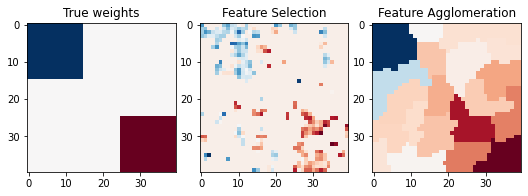

In [12]:
plt.close("all")
plt.figure(figsize=(7.3, 2.7))
plt.subplot(1, 3, 1)
plt.imshow(coef, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("True weights")
plt.subplot(1, 3, 2)
plt.imshow(coef_selection_, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("Feature Selection")
plt.subplot(1, 3, 3)
plt.imshow(coef_agglomeration_, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("Feature Agglomeration")
plt.subplots_adjust(0.04, 0.0, 0.98, 0.94, 0.16, 0.26)
plt.show()

Tentative de suppression du cachedir temporaire, mais ne vous inquiétez pas si cela échoue.

In [13]:
shutil.rmtree(cachedir, ignore_errors=True)